In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def smooth(track, window_size):
    """
    Smooth out time series using a simple moving average.
    
    Parameters:
        pnl (list or Series): List or Series containing P&L data.
        window_size (int): Size of the moving average window.
        
    Returns:
        smoothed_pnl (Series): Smoothed P&L using moving average.
    """
    track_series = pd.Series(track)
    smoothed_track = track_series.rolling(window=window_size).mean()
    return smoothed_track

def kelly(decimal_odds, P, fractional):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * fractional
    return solution

# def remove_outliers(pnl, threshold=3):
#     """
#     Remove outliers from P&L data using z-score.
    
#     Parameters:
#         pnl (list or Series): List or Series containing P&L data.
#         threshold (float): Threshold value for z-score. Default is 3.
        
#     Returns:
#         cleaned_pnl (list or Series): P&L data with outliers removed.
#     """
#     pnl_array = np.array(pnl)
#     z_scores = np.abs((pnl_array - np.mean(pnl_array)) / np.std(pnl_array))
#     cleaned_pnl = pnl_array[z_scores < threshold]
#     return cleaned_pnl

In [3]:
def backtest(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    #df = df[df['Sportsbooks_Odds'] < 2.00]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * balance # balance
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    smooth_track = smooth(track, 10)
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    plt.title('PnL Over Time')
    
    plt.show()  # Show the first plot
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], track, c='b')
    plt.plot(df['Date'], smooth_track, c='r')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Bankroll($)', size=17)
    plt.title('Bankroll Over Time')
    
    plt.show()
    first_day = df['Date'].min().date()
    last_day = df['Date'].max().date()
    
    print('\n')
    print(f'The position was held from {first_day} to {last_day}, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')

In [4]:
import numpy as np

def calculate_max_drawdown(series):
    """
    Calculate drawdown from a time series of equity values.
    """
    max_dd = 0
    peak = series[0]
    drawdowns = []
    
    for val in series:
        if val > peak:
            peak = val
        dd = (peak - val) / peak
        drawdowns.append(dd)
        max_dd = max(max_dd, dd)
    
    return max_dd

def backtest_for_calmar(df, initial, shrinkage, threshold):
    """
    Backtest function to calculate the Calmar ratio.
    
    Parameters:
        df (DataFrame): DataFrame containing the backtest data.
        initial (float): Initial balance.
        shrinkage (float): Shrinkage factor for Kelly criterion.
        threshold (float): Minimum threshold for placing a bet.
        
    Returns:
        calmar_ratio (float): Calmar ratio.
    """
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index, row in df.iterrows():
        bet_amount = row['Kelly'] * balance
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
    
    max_drawdown = calculate_max_drawdown(track)
    periods = len(df)
    avg_return = np.mean(returns_list)
    
    if max_drawdown == 0:
        calmar_ratio = np.inf  # To handle division by zero
    else:
        calmar_ratio = avg_return / max_drawdown
    
    return calmar_ratio, periods


In [5]:
def backtest_for_sharpe(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * balance
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    return sharpe_ratio, periods

In [6]:
pwd

'/Users/benjamincheng/Documents/GitHub/Sports-Betting/risk_management'

In [7]:
save_path = '/Users/benjamincheng/Documents/GitHub/Sports-Betting/risk_management/'
file_name = "calibrated_adjusted_index_predictions.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0, parse_dates=['Date'])

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [8]:
df

,Teams_x,Teams_y,Fanduel_odds_x,Draftkings_odds_x,BetMGM_odds_x,Fanduel_odds_y,Draftkings_odds_y,BetMGM_odds_y,Date,Predictions,Actual,Sportsbooks_Odds,Probabilities
0,CHO,PHI,4.85,4.90,4.75,1.20,1.20,1.20,2023-03-17,0,0,4.90,0.180000
1,BRK,SAC,1.72,1.74,1.71,2.18,2.15,2.15,2023-03-16,1,0,1.74,0.595238
2,OKC,TOR,3.05,3.15,3.20,1.40,1.39,1.36,2023-03-16,0,0,3.20,0.264901
3,POR,BOS,2.60,2.60,2.55,1.53,1.53,1.53,2023-03-17,0,0,2.60,0.395455
4,CLE,WAS,1.48,1.48,1.44,2.76,2.80,2.80,2023-03-17,1,1,1.48,0.620690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,MIA,CLE,2.10,2.10,2.05,1.77,1.77,1.77,2024-03-20,0,1,2.10,0.426471
1778,UTA,OKC,9.10,9.00,9.00,1.07,1.07,1.07,2024-03-20,0,0,9.10,0.000000
1779,POR,LAC,6.60,6.25,6.50,1.12,1.13,1.12,2024-03-20,0,0,6.60,0.180000
1780,SAC,TOR,1.16,1.16,1.15,5.60,5.55,5.75,2024-03-20,1,1,1.16,0.785714


In [9]:
final = df.copy()
final['Our_Odds'] = 1 / final['Probabilities']
column_order = ['Date', 'Teams_x', 'Sportsbooks_Odds','Our_Odds','Probabilities','Predictions', 'Actual']
#'Our_Odds'
final = final[column_order]
win = final[final['Predictions'] == 1]
bet = win[win['Our_Odds'] < win['Sportsbooks_Odds']]
bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']

/var/folders/99/zv3w4flx1598dxlknc099kfr0000gn/T/ipykernel_91293/1898229783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']


In [10]:
final[final['Date'] == '2023-11-30']

,Date,Teams_x,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual
308,2023-11-30,SAS,3.50,3.775000,0.264901,0,0
324,2023-11-30,IND,2.10,2.528736,0.395455,0,0
325,2023-11-30,POR,5.30,5.555556,0.180000,0,1
328,2023-11-30,ATL,1.33,1.500000,0.666667,1,1
329,2023-11-30,CLE,1.17,1.272727,0.785714,1,0
330,2023-11-30,GSW,1.49,1.611111,0.620690,1,1
332,2023-11-30,CHI,3.90,3.775000,0.264901,0,1
333,2023-11-30,MIN,1.19,1.272727,0.785714,1,1
334,2023-11-30,OKC,1.44,1.611111,0.620690,1,1
336,2023-11-30,BRK,1.29,1.293103,0.773333,1,0


### Sharpe Ratio Tuning

In [16]:
# we want at least trade_count trades
greatest_sharp = 0
best_threshold = 0
best_return = 0 
traded = 0
best_spread = 0
best_shrink = 0

trade_count = 10

for spread in range(100):
    spread = spread / 100
    bet_very_undervalued = bet[bet['odds_diff'] > spread]
    if len(bet_very_undervalued) < trade_count:
        continue
    for shrink in range(1,100):
        shrink = shrink/100
        for i in range(100, 200):
            threshold = i / 100
            sharp, periods = backtest_for_sharpe(bet_very_undervalued, 6000, shrink, threshold)
            if sharp > greatest_sharp and periods > trade_count:
                greatest_sharp = sharp
                best_threshold = threshold
                traded = periods
                best_spread = spread
                best_shrink = shrink
    print(f'{spread}/1')
print(f'The greatest sharpe ratio is: {greatest_sharp}')
print(f'The odds threshold is: {best_threshold}')
print(f'The best spread: {best_spread}')
print(f'The best shrinkage: {best_shrink}')
print(f'The algorithm traded: {traded} times')

0.0/1
0.01/1
0.02/1
0.03/1
0.04/1
0.05/1
0.06/1
0.07/1
0.08/1
0.09/1
0.1/1
0.11/1
0.12/1
0.13/1
0.14/1
0.15/1
0.16/1
0.17/1
0.18/1
0.19/1
0.2/1
0.21/1
0.22/1
0.23/1
0.24/1
0.25/1
0.26/1
0.27/1
0.28/1
0.29/1
0.3/1
0.31/1
0.32/1
The greatest sharpe ratio is: 2.3138928478282463
The odds threshold is: 1.1
The best spread: 0.01
The best shrinkage: 0.01
The algorithm traded: 246 times


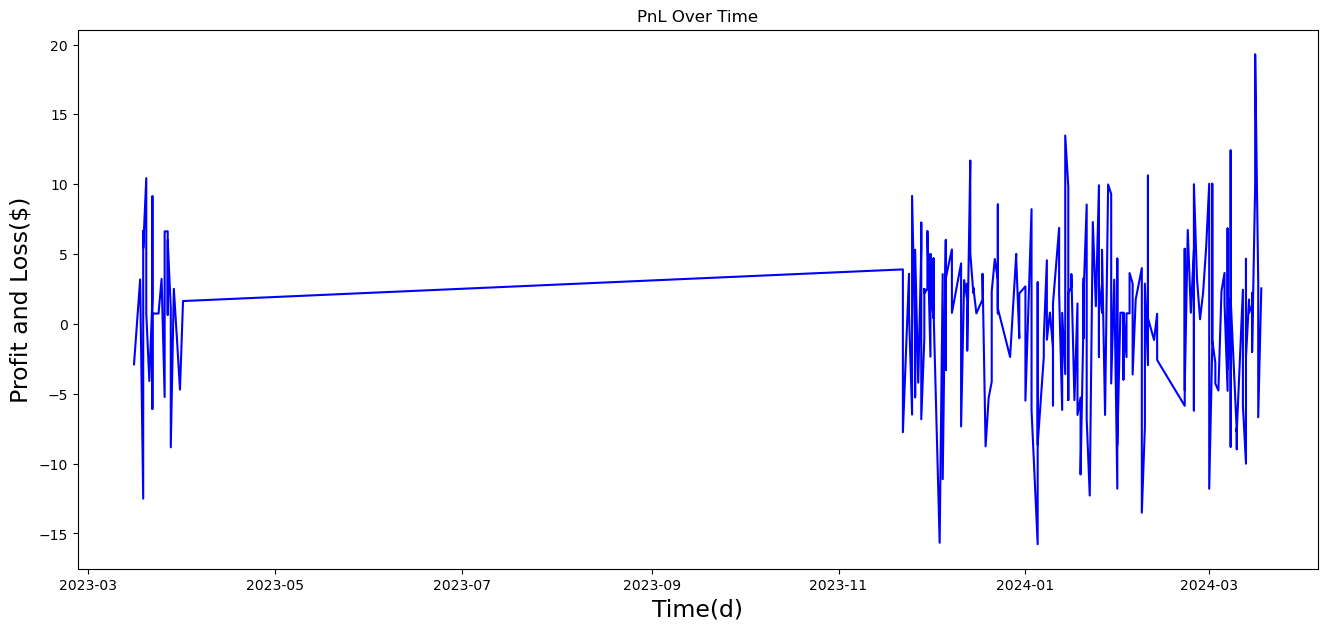

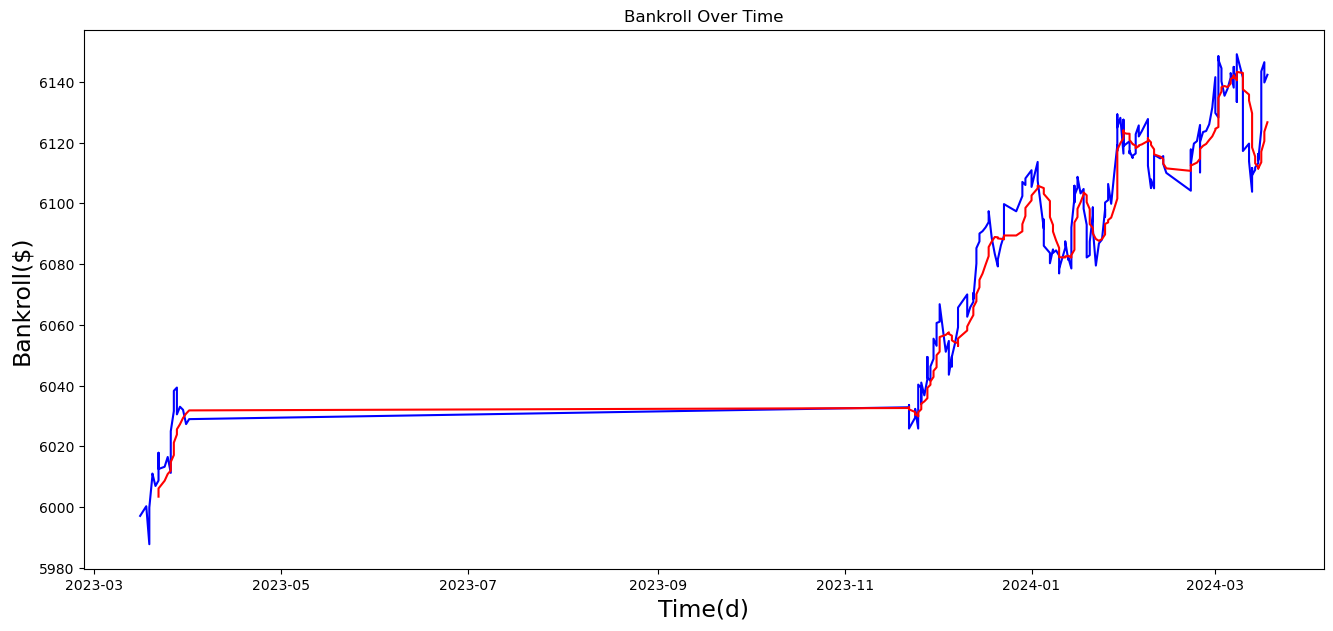



The position was held from 2023-03-16 to 2024-03-18, traded 246 times, and produced a return of 2.3720%.
The growth rate on each bet was 0.0095%.
The final balance is $6142.32.
The average of returns is 1.4941%.
The standard deviation of returns is 0.6457%.


The Sharpe Ratio of the strategy is 2.3139.


In [17]:
threshold_sharpe = 1.1
spread_sharpe = 0.01
shrink_sharpe = 0
bet_sharpe = bet[bet['odds_diff'] > spread_sharpe]
backtest(bet_sharpe, 6000, 0.01, threshold_sharpe)

### Calmar Ratio Tuning
This is the best strategy thus far 

In [20]:
# we want at least 100 trades
greatest_calmar = 0
best_threshold = 0
best_return = 0 
traded = 0
best_spread = 0
best_shrink = 0 

trade_count = 30

for spread in range(100):
    spread = spread / 100
    bet_very_undervalued = bet[bet['odds_diff'] > spread]
    if len(bet_very_undervalued) < trade_count:
        continue
    for shrink in range(1,100):
        shrink = shrink/100
        for i in range(100, 200):
            threshold = i / 100
            calmar,periods = backtest_for_calmar(bet_very_undervalued, 6000, shrink, threshold)
            if calmar > greatest_calmar and periods > trade_count:
                greatest_calmar = calmar
                best_threshold = threshold
                traded = periods
                best_spread = spread
                best_shrink = shrink
    print(f'{spread}/1')
print(f'The greatest calmar ratio is: {greatest_calmar}')
print(f'The odds threshold is: {best_threshold}')
print(f'The best spread: {best_spread}')
print(f'The best shrinkage: {best_shrink}')
print(f'The algorithm traded: {traded} times')

0.0/1
0.01/1
0.02/1
0.03/1
0.04/1
0.05/1
0.06/1
0.07/1
0.08/1
0.09/1
0.1/1
0.11/1
0.12/1
0.13/1
0.14/1
0.15/1
0.16/1
0.17/1
0.18/1
0.19/1
0.2/1
0.21/1
0.22/1
0.23/1
0.24/1
The greatest calmar ratio is: 377.3395178883241
The odds threshold is: 1.1
The best spread: 0.06
The best shrinkage: 0.89
The algorithm traded: 143 times


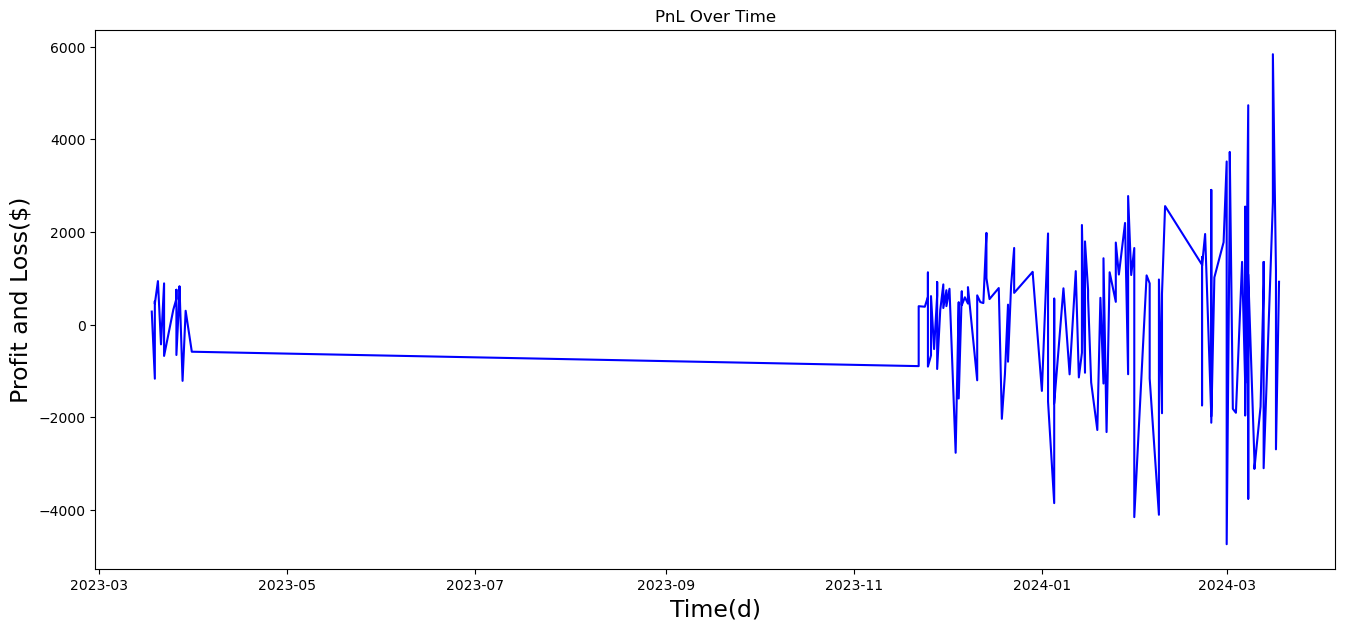

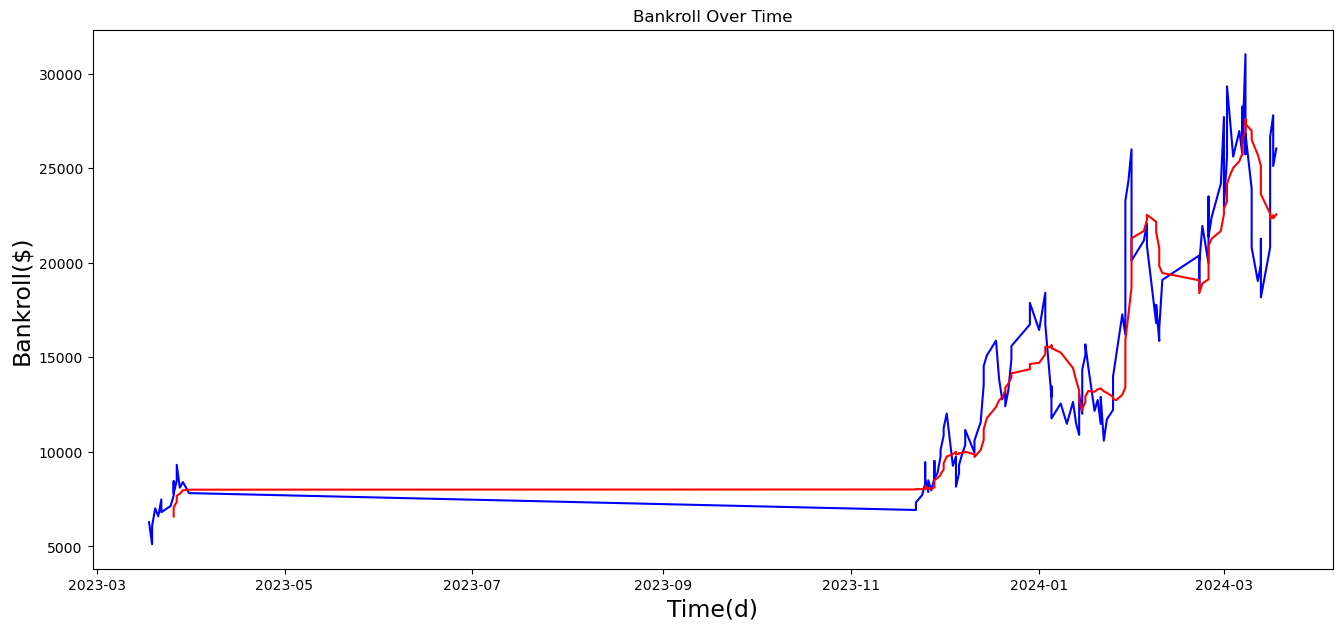



The position was held from 2023-03-18 to 2024-03-18, traded 143 times, and produced a return of 334.0598%.
The growth rate on each bet was 1.0319%.
The final balance is $26043.59.
The average of returns is 160.2910%.
The standard deviation of returns is 109.4221%.


The Sharpe Ratio of the strategy is 1.4649.


In [25]:
threshold_calmar = 1.1
spread_calmar = 0.06
shrink_calmar = 0.89 
bet_calmar = bet[bet['odds_diff'] > spread_calmar]
backtest(bet_calmar, 6000, shrink_calmar, threshold_calmar)

### Check the convex optimization of initial vs balance with shrinkage, initial with shrinkage vs balance with shrinkage